In [1]:
import os
import pandas as pd
from pyspark.ml.feature import StringIndexer, OneHotEncoder
import plotly.express as px
import json

os.chdir('../')


In [2]:

from Utils.SparkSessionManager import SparkSessionManager
from Service.DataReader import DataReader
from Service.VMAnalyzer import VMAnalyzer

In [3]:
spark = SparkSessionManager.create_session()
dt_reader = DataReader(spark)
with open('settings.json', 'r') as file:
    data = json.load(file)

local_settings = data['Prod']
filepath = local_settings['filepath']
input_file = local_settings['input']

csv_file, vmSchema = dt_reader.read_data(filepath, input_file)
dt_analyzer = VMAnalyzer(spark, csv_file, vmSchema)


In [4]:
dataFrame = dt_analyzer.get_df()
processed_df = dt_analyzer.pre_processing_pipeline()

In [5]:
columns = ["baseScore", "impactScore", "exploitabilityScore"]
dt_analyzer.calculate_range(dataFrame, columns)

+-------------+-------------+---------------+---------------+-----------------------+-----------------------+
|min_baseScore|max_baseScore|min_impactScore|max_impactScore|min_exploitabilityScore|max_exploitabilityScore|
+-------------+-------------+---------------+---------------+-----------------------+-----------------------+
|          2.1|          9.8|            1.4|            6.0|                    0.5|                    3.9|
+-------------+-------------+---------------+---------------+-----------------------+-----------------------+



+----+-----------------+
|Year|       Base Score|
+----+-----------------+
|2018|6.700000047683716|
|2019|5.542857136045184|
|2020|6.728846238209651|
|2021|6.703225889513569|
+----+-----------------+



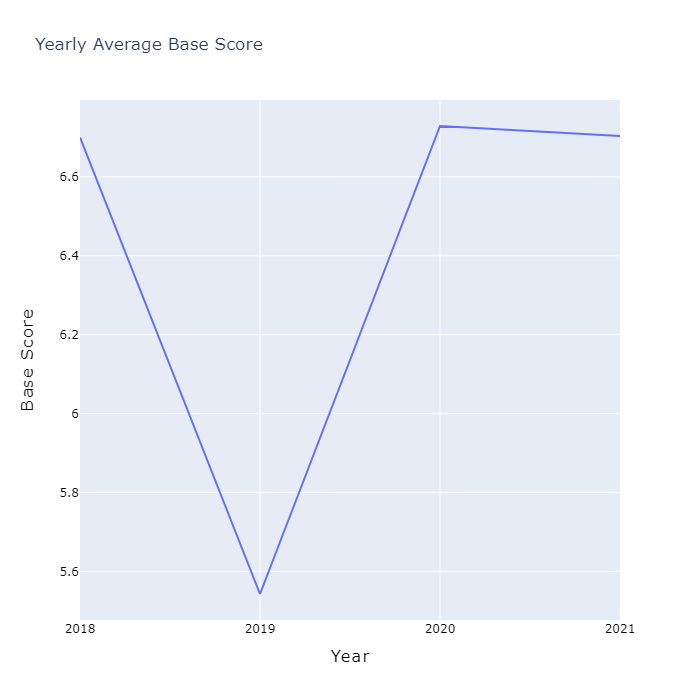

In [6]:
mean_df_base_score = dt_analyzer.calculate_mean_category(dataFrame, "year", "baseScore", "Year", "Base Score", True)
options = {
    'xAxisLabel': "<span style='letter-spacing: 1.3px;'>Year</span>",
    'yAxisLabel': "<span style='letter-spacing: 1.3px;'>Base Score</span>",
    'width': 700,
    'height': 700,
    'title': "Yearly Average Base Score",
    'format': "png",
    'font_size': 16,
    'font_color': "black",
    'value_color': "black",
    'value_size': 12
}
dt_analyzer.show_line_chart(mean_df_base_score, "Year", "Base Score", options)

+----------------+----------+
|   Attack Vector|Base Score|
+----------------+----------+
|           LOCAL|       7.8|
|         NETWORK|       9.8|
|        PHYSICAL|       4.6|
|ADJACENT NETWORK|       6.5|
+----------------+----------+

+----------------+-----------------+
|   Attack Vector|       Base Score|
+----------------+-----------------+
|           LOCAL|6.308571508952549|
|         NETWORK|7.321052701849687|
|        PHYSICAL|5.559375017881393|
|ADJACENT NETWORK|7.485000109672546|
+----------------+-----------------+



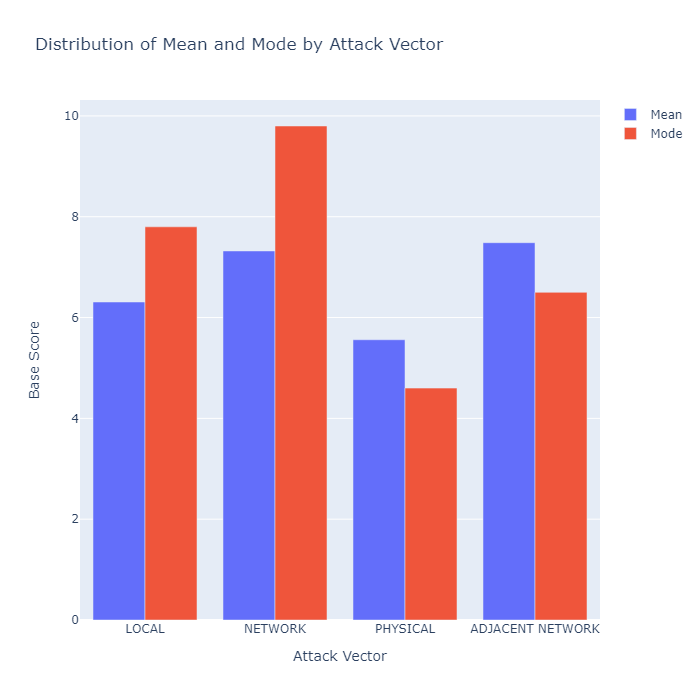

In [7]:

mode_df_base_score = dt_analyzer.calculate_mode_category(dataFrame, "attackVector", "baseScore", "Attack Vector", "Base Score")
mean_df_base_score = dt_analyzer.calculate_mean_category(dataFrame, "attackVector", "baseScore", "Attack Vector", "Base Score")
options = {
    'xAxisLabel': "<span style='letter-spacing: 1.3px;'>Attack Vector</span>",
    'yAxisLabel': "<span style='letter-spacing: 1.3px;'>Base Score</span>",
    'width': 700,
    'height': 700,
    'title': "Distribution of Mean and Mode by Attack Vector",
    'format': "png",
    'font_size': 16,
    'font_color': "black",
    'value_color': "black",
    'value_size': 12
}
dt_analyzer.show_go_bar_chart_mean_mode(mode_df_base_score, mean_df_base_score, "Attack Vector", "Base Score", options)



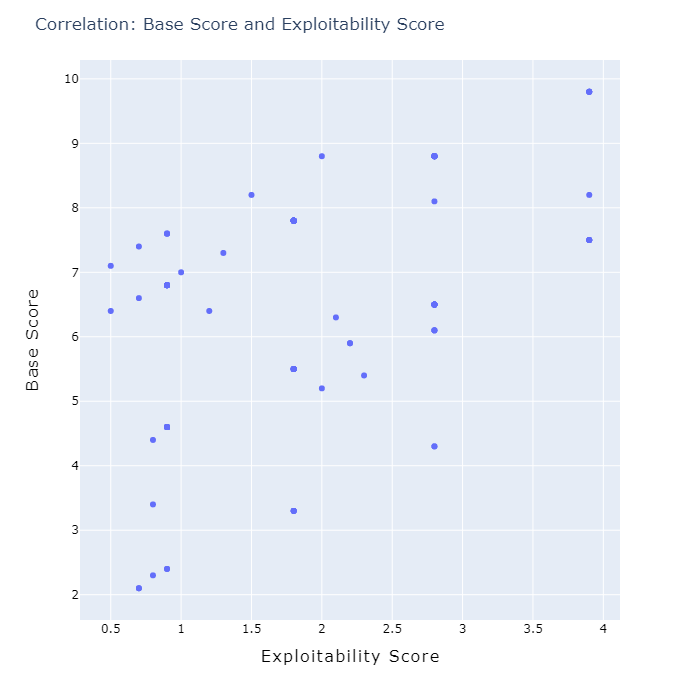

In [8]:
options = {
    'xAxis': "<span style='letter-spacing: 1.3px;'>Exploitability Score</span>",
    'yAxis': "<span style='letter-spacing: 1.3px;'>Base Score</span>",
    'width': 700,
    'height': 700,
    'title': "Correlation: Base Score and Exploitability Score",
    'format': "png",
    'font_size': 16,
    'font_color': "black",
}
dt_analyzer.show_correlation_scatter_plot(processed_df, "exploitabilityScore", "baseScore", options)

+----------------+------------+-----+
|    attackVector|baseSeverity|count|
+----------------+------------+-----+
|           LOCAL|        HIGH|   19|
|ADJACENT_NETWORK|        HIGH|    9|
|        PHYSICAL|         LOW|    4|
|           LOCAL|         LOW|    6|
|        PHYSICAL|      MEDIUM|   23|
|         NETWORK|        HIGH|    7|
|         NETWORK|      MEDIUM|    8|
|         NETWORK|    CRITICAL|    4|
|           LOCAL|      MEDIUM|   10|
|        PHYSICAL|        HIGH|    5|
|ADJACENT_NETWORK|      MEDIUM|   11|
+----------------+------------+-----+



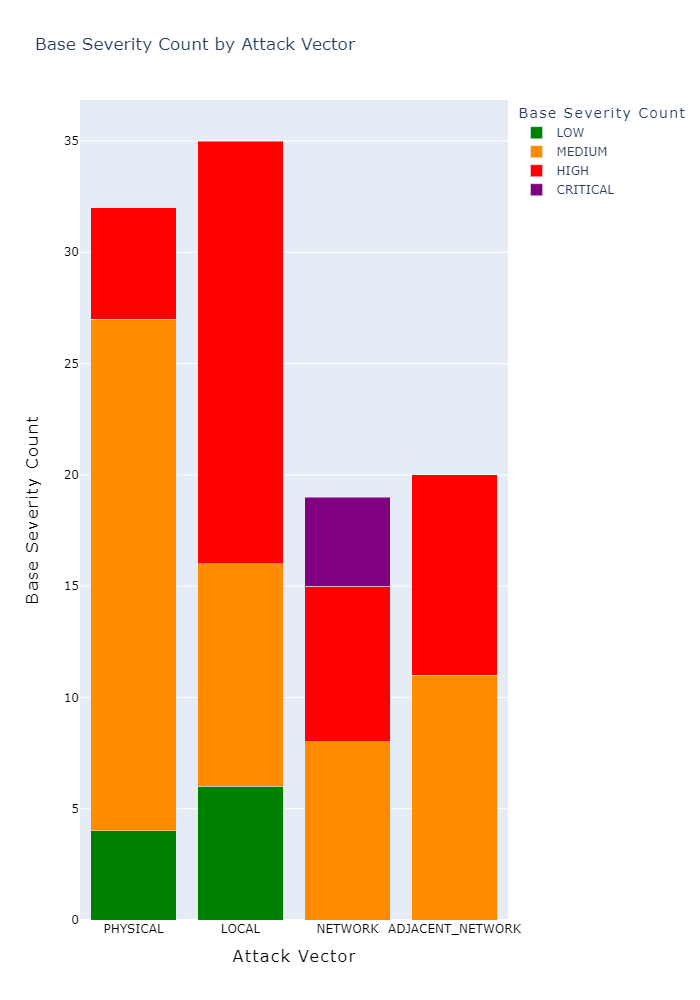

In [9]:
options = {
    'xAxisLabel': "<span style='letter-spacing: 1.3px;'>Attack Vector</span>",
    'yAxisLabel': "<span style='letter-spacing: 1.3px;'>Base Severity Count</span>",
    'width': 700,
    'height': 1000,
    'title': "Base Severity Count by Attack Vector",
    'format': "png",
    'font_size': 16,
    'font_color': "black",
    'value_color': "black",
    'value_size': 12
}
dt_analyzer.show_correlation_stacked_bar_chart(processed_df, "attackVector", "baseSeverity", options)

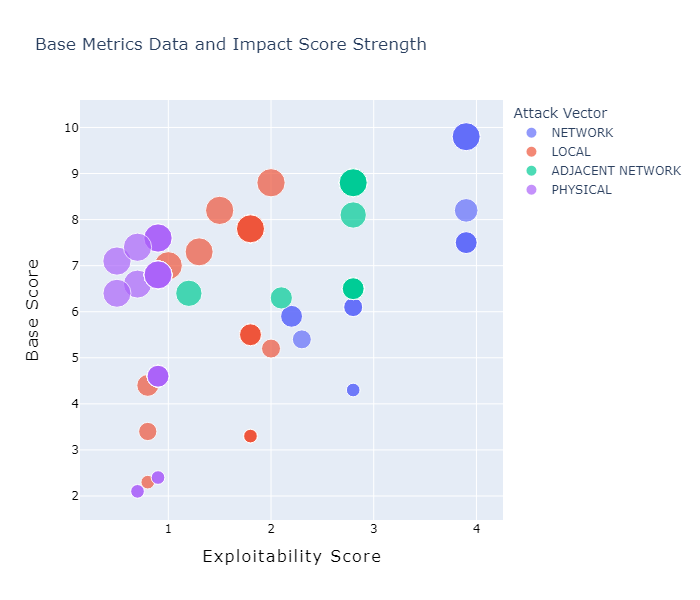

In [10]:
options = {
    'xAxisLabel': "<span style='letter-spacing: 1.3px;'>Exploitability Score</span>",
    'yAxisLabel': "<span style='letter-spacing: 1.3px;'>Base Score</span>",
    'width': 700,
    'height': 600,
    'title': "Base Metrics Data and Impact Score Strength",
    'format': "png",
    'font_size': 16,
    'font_color': "black",
    'value_color': "black",
    'value_size': 12,
     'size_col': "impactScore",
     'color_col': "attackVector",
     'key_label': "Attack Vector"
}
dt_analyzer.show_bubble_chart(
   processed_df, 
  "exploitabilityScore",
  "baseScore", 
   options
  )

0.7128366910587471
Correlation matrix:
                        Confidentiality Impact  Integrity Impact  \
Confidentiality Impact                1.000000          0.712837   
Integrity Impact                      0.712837          1.000000   
Availability Impact                   0.437245          0.593336   

                        Availability Impact  
Confidentiality Impact             0.437245  
Integrity Impact                   0.593336  
Availability Impact                1.000000  


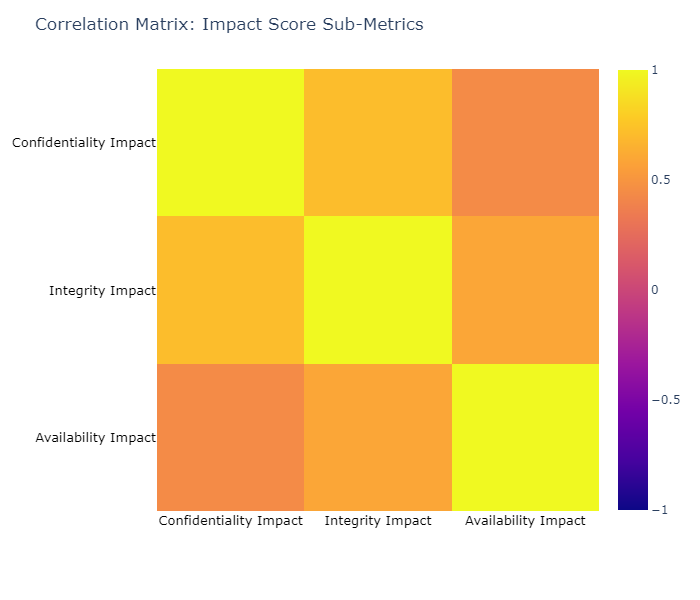

In [11]:
dt_analyzer.check_correlation(processed_df, "ConfidentialityImpactNumeric", "IntegrityImpactNumeric")
column_display_info = [
    {"column_name": "ConfidentialityImpactNumeric", "display_name": "Confidentiality Impact"},
    {"column_name": "IntegrityImpactNumeric", "display_name": "Integrity Impact"},
    {"column_name": "AvailabilityImpactNumeric", "display_name": "Availability Impact"}
]
correlation_df = dt_analyzer.calculate_correlation(processed_df, column_display_info)
options = {
    'width': 700,
    'height': 600,
    'title': "Correlation Matrix: Impact Score Sub-Metrics",
    'format': "png",
    'font_size': 16,
    'font_color': "black",
    'value_color': "black",
    'value_size': 13,
}
dt_analyzer.show_heatmap(correlation_df, options)

In [12]:
columns_clustering = ['baseScore', 'exploitabilityScore', 'impactScore']
dt_analyzer.clustering_pipeline(processed_df, columns_clustering)

Silhouette Score: 0.604558152270233
Silhouette Score: 0.5469080680631113
Silhouette Score: 0.6706191704595436
Silhouette Score: 0.6243045926879651
Silhouette Score: 0.733897307579535
Silhouette Score: 0.7040148466047583
   baseScore  exploitabilityScore  impactScore
0   0.604558             0.604558     0.604558
1   0.546908             0.546908     0.546908
2   0.670619             0.670619     0.670619
3   0.624305             0.624305     0.624305
4   0.733897             0.733897     0.733897
5   0.704015             0.704015     0.704015
